# Processing SUMO Results

Read data and fill in missing edges with 0.

In [1]:
import pandas as pd

city = "sfc"

data = pd.read_csv("out/routeSampler/" + city + ".edgedata.csv", sep=";")[["edge_id", "edge_entered", "edge_speed"]].rename(columns={
    "edge_entered": "flow",
    "edge_speed": "vehicle_speed"})
#data["flow"] = data["flow"].apply(lambda x : x / 24)
data.head()

,edge_id,flow,vehicle_speed
0,0,2090,26.36
1,1,67,27.26
2,1000,756,26.43
3,10003,1390,25.48
4,10004,3429,24.97


In [2]:
len(data.index)

39886

In [3]:
covered_edges = data["edge_id"].unique()

for i in range(1220):
    if i not in covered_edges:
        data.loc[len(data.index)] = [i, 0, 0.0]
        
data["edge_id"].nunique()

40379

Read edges and features.

In [4]:
edgelist = pd.read_csv("out/" + city + ".edges.csv", sep=";")
edgelist.head()

,edge_from,edge_id,edge_length,edge_numLanes,edge_speed,edge_to
0,663028776,0,85.856322,5,29.0576,32915539
1,349678308,1,33.691470,2,29.0576,349678300
2,120816570,2,13.396196,1,29.0576,3971849316
3,31354482,3,174.514680,2,29.0576,31416669
4,62292066,4,20.349926,1,29.0576,62292068


In [5]:
edgelist = pd.merge(edgelist, data, on="edge_id")

ordered_cols = ["edge_id", "edge_from", "edge_to", "edge_length", "edge_numLanes", "edge_speed", "flow", "vehicle_speed"]
edgelist = edgelist[ordered_cols]

edgelist.head()

,edge_id,edge_from,edge_to,edge_length,edge_numLanes,edge_speed,flow,vehicle_speed
0,0,663028776,32915539,85.856322,5,29.0576,2090.0,26.36
1,1,349678308,349678300,33.691470,2,29.0576,67.0,27.26
2,2,120816570,3971849316,13.396196,1,29.0576,0.0,0.00
3,3,31354482,31416669,174.514680,2,29.0576,767.0,17.33
4,4,62292066,62292068,20.349926,1,29.0576,0.0,0.00


Check values for flow and speed.

In [6]:
edgelist["flow"].nunique()

2318

In [7]:
(edgelist["flow"] == 0).sum()

731

In [8]:
edgelist["flow"].median()

1256.0

In [9]:
(edgelist["vehicle_speed"] < 1).sum()

533

In [10]:
edgelist.to_csv("out/" + city + ".results.csv", index=False)

In [11]:
nodes = pd.read_csv("out/" + city + ".nodes.csv", sep=";").set_index("node_id")
nodes.head()

,node_x,node_y
node_id,,
1373634581,-122.108646,38.024515
1335885865,-122.291325,38.117516
3974627383,-122.515574,37.928089
3974627384,-122.515807,37.929306
767819860,-122.392965,37.704484


## Visualizations

Flow at each edge:

In [12]:
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt


positions = {v: (k["node_x"], k["node_y"]) for v, k in nodes.to_dict("index").items()}
cmap = mpl.colormaps["viridis"]

G = nx.from_pandas_edgelist(edgelist, source="edge_from", target="edge_to", edge_attr=["edge_id", "edge_numLanes", "edge_speed",
                                                                                      "flow", "vehicle_speed"],
                           create_using=nx.DiGraph)
G.number_of_edges()

40379

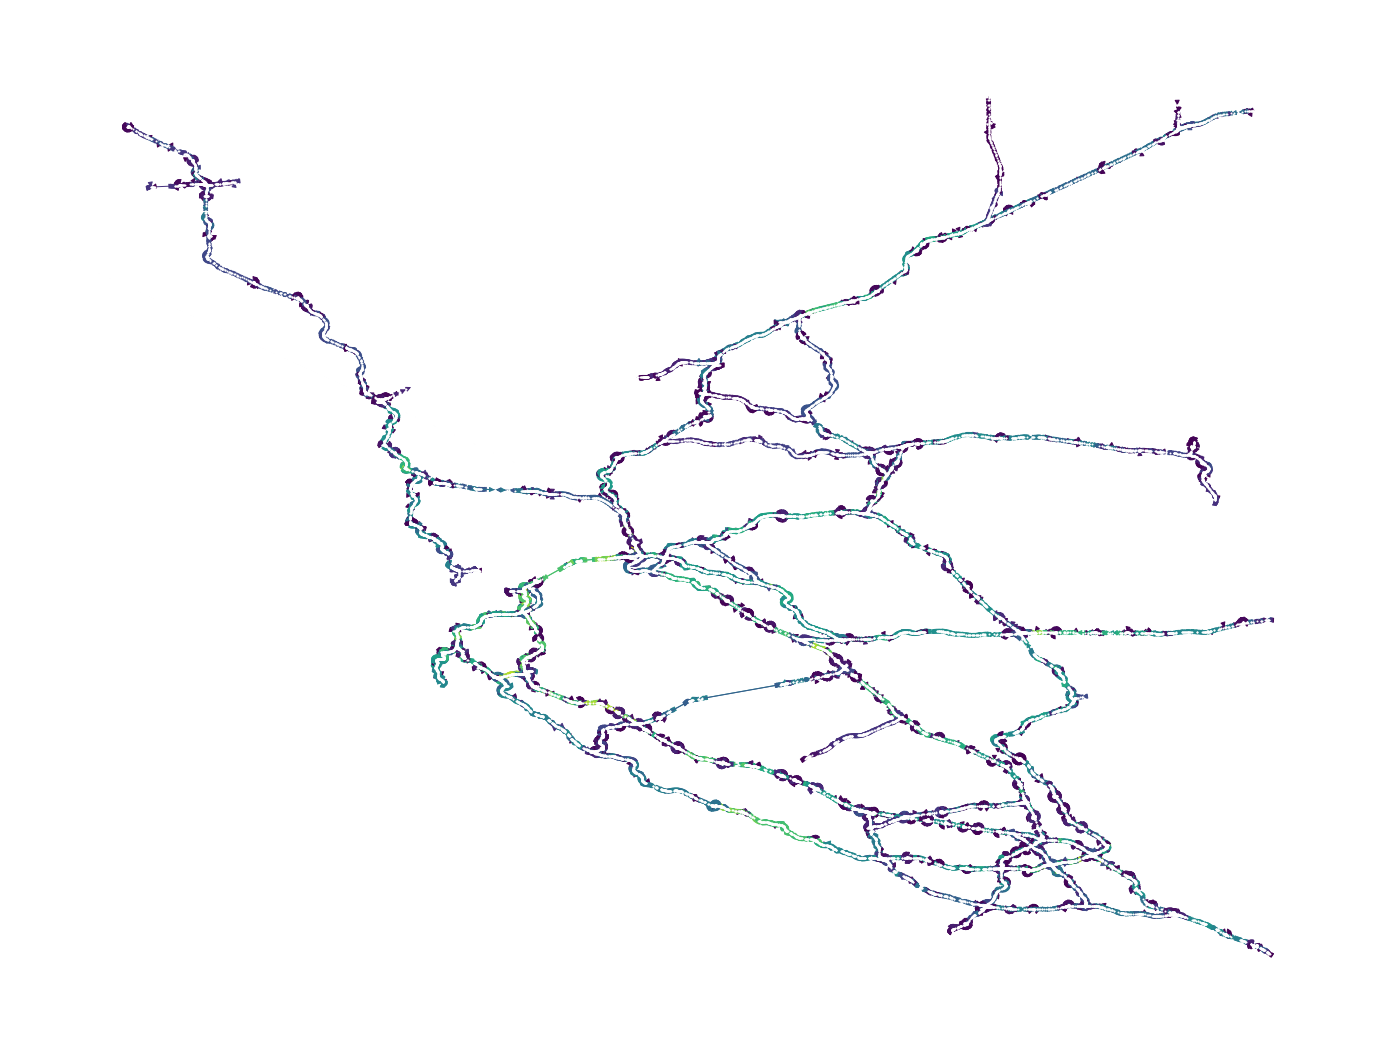

In [13]:
nx.set_node_attributes(G, nodes.to_dict("index"))

plt.figure(figsize=[3 * x for x in [6.4, 4.8]])
edge_colors = [(G[u][v]["flow"]) for u, v in G.edges]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=edge_colors)
plt.show()

Edges with 0 flow (in red):

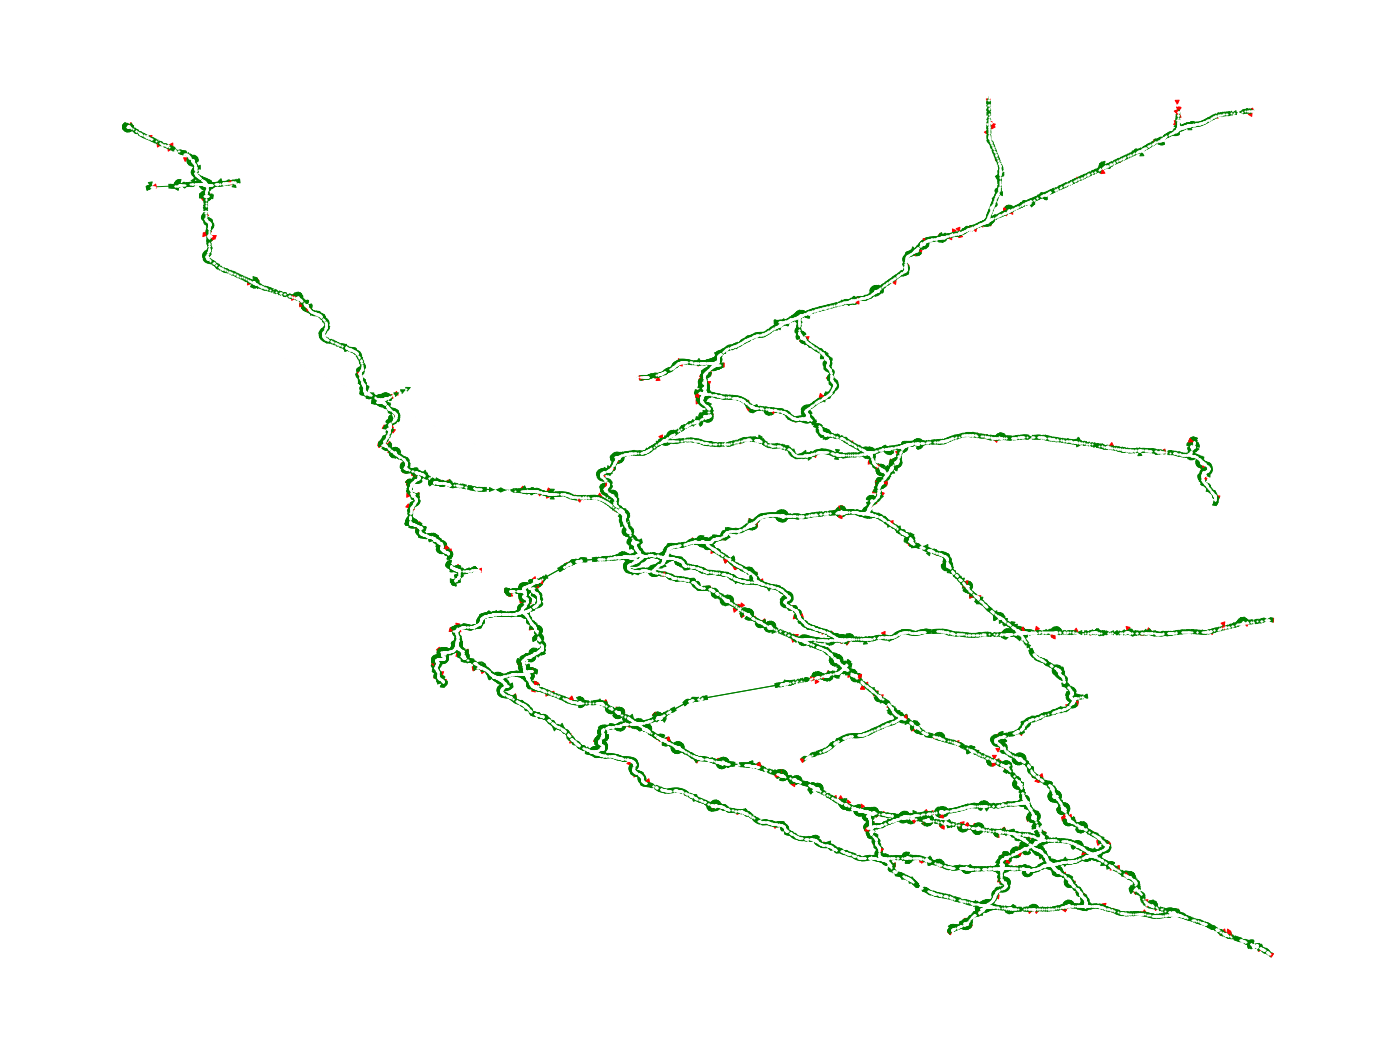

In [14]:
plt.figure(figsize=[3 * x for x in [6.4, 4.8]])
edge_colors = ["red" if G[u][v]["flow"] == 0 else "green" for u,v in G.edges]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=edge_colors)
plt.show()

Speeds at each edge:

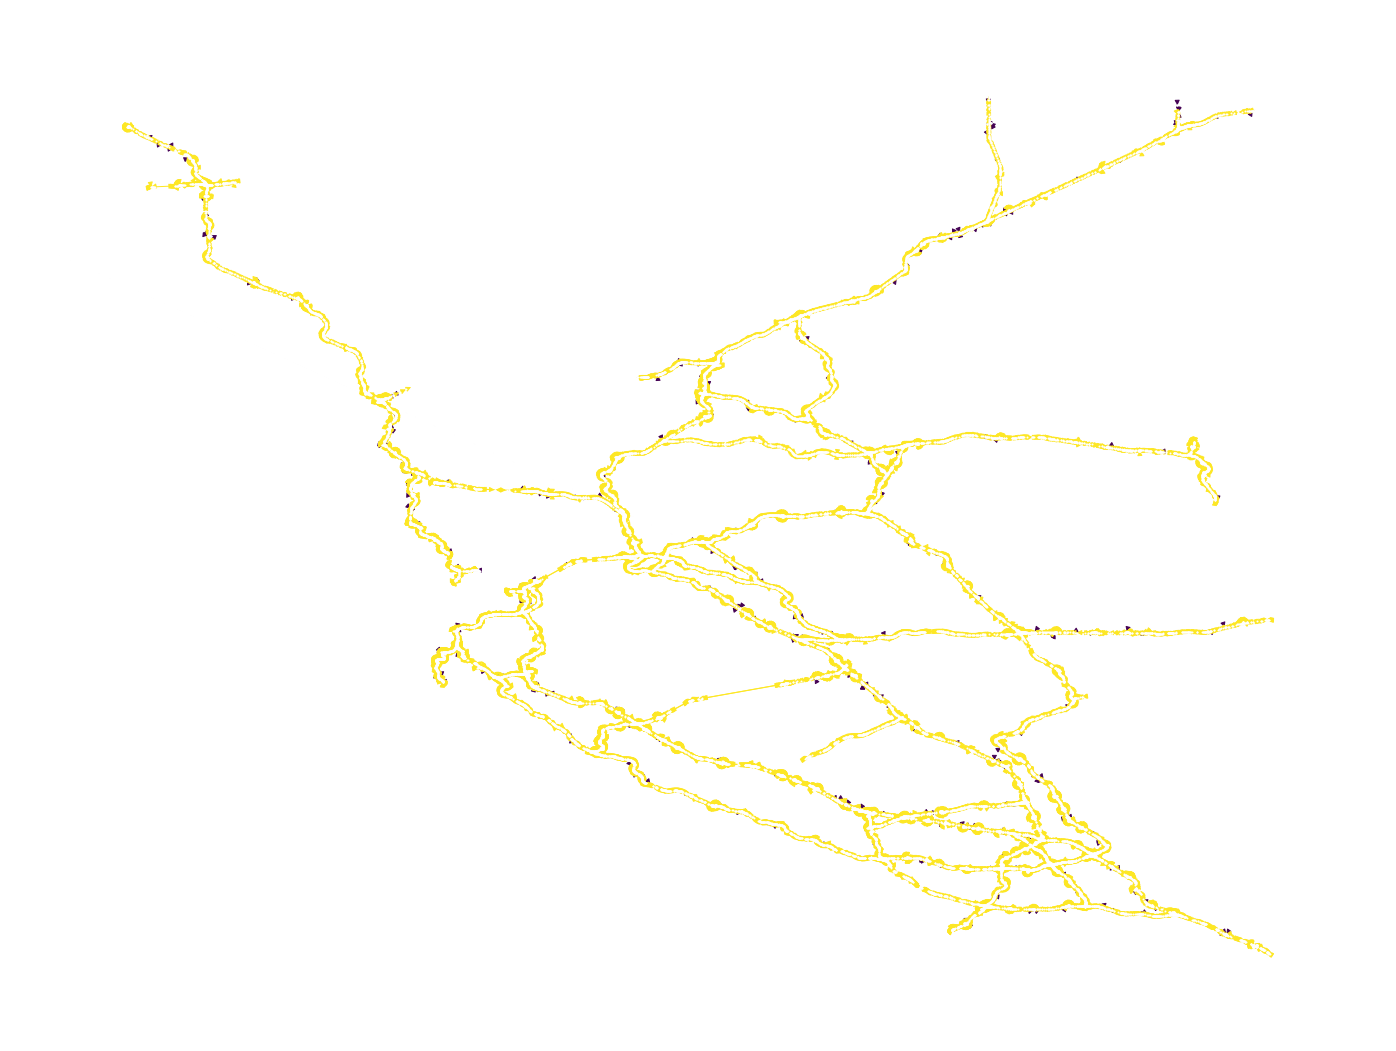

In [15]:
plt.figure(figsize=[3 * x for x in [6.4, 4.8]])
edge_colors = [cmap(G[u][v]["vehicle_speed"]) for u, v in G.edges]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=edge_colors)
plt.show()

## Validation

In [13]:
import pickle 
import numpy as np

with open('data/' + city + '_speeds.pkl', 'rb') as f:
    speeds = pickle.load(f)

with open('data/' + city + '_flows.pkl', 'rb') as f:
    flows = pickle.load(f)

GEH statistic for sensor locations (a good error is GEH<5 for at least 90% of sensors):

In [14]:
detectors = []

sat = 0

for k, c in flows.items():
    u, v = [int(i) for i in k]
    try:
        m = G[u][v]["flow"] / 3
    except:
        continue
    geh = np.sqrt(2 * (m - c) ** 2 / (m + c))
    sat += (geh < 5)
    detectors.append(G[u][v]["edge_id"])
    print(G[u][v]["edge_id"], m, c, geh)
    
print("GEH<5 for", 100 * sat / len(detectors), "%")

39 1431.0 8425.318872017353 99.63296462079337
41 0.0 67.94501246882793 11.657187694193478
48 0.0 336.8840768865686 25.957044395946493
147 870.0 5348.190661034365 80.31294672051716
172 876.0 2904.2422650987555 46.65250945229727
190 690.3333333333334 2071.6882064162573 37.17121281355291
198 1409.0 4226.2769722571065 53.07462204075769
201 860.3333333333334 2581.2653270921337 41.485716427855614
224 588.0 2168.236442516269 42.56756771517497
229 343.0 1418.090078776116 36.23006112046001
260 664.0 1992.585569128896 36.45378469006226
280 2.0 6.845744680851064 2.3041371466746274
305 0.0 99.63790446841294 14.116508383337074
335 462.6666666666667 4105.094759675762 76.21742610872369
425 961.3333333333334 3075.493891996803 47.0579369171395
453 1592.6666666666667 4779.661947710926 56.46084016044655
463 0.0 341.218557190318 26.12349736120024
530 1056.6666666666667 3391.5661605206074 49.509601810730196
542 0.0 501.5270812437312 31.67103033511007
549 94.0 282.5705625606208 13.742498902533347
551 429.33

15565 881.3333333333334 6056.212467176619 87.86426428841821
15572 62.666666666666664 188.7725213890287 11.246924120116674
15576 525.3333333333334 2194.9004452563076 45.27054932851952
15577 1052.6666666666667 3486.952620162119 51.094820136437036
15644 124.33333333333333 373.7681640393505 15.805679518791502
15769 1225.0 3973.7267952962666 53.91356825779
15808 53.666666666666664 351.1429757949692 20.90941863631336
15905 1395.0 4911.588651672565 62.62378538092429
15935 966.6666666666666 3285.9063820070783 50.296150399132415
15963 1047.3333333333333 3142.948738440461 45.78307418392939
16001 501.0 1503.7358145907067 31.67181486625112
16033 993.3333333333334 2980.3343989039845 44.57766569811724
16036 995.3333333333334 3230.178102523119 48.620869349916795
16037 624.0 1873.0885945884233 35.350150341499294
16066 362.3333333333333 1496.5920767210869 37.204558187761485
16113 312.6666666666667 1875.9562735472086 47.25730652061204
16116 1298.0 4251.8993035734675 56.07485155203962
16124 1146.0 3438.8

32646 1476.6666666666667 4464.324580431556 54.81714476846545
32661 964.3333333333334 2892.9155154698024 43.91514477713348
32688 1239.6666666666667 3718.0498915401304 49.77859240360296
32704 755.6666666666666 2950.8482703504965 50.99206209988206
32823 1073.0 4007.3794953761844 58.22147447104262
32834 1319.6666666666667 3960.074780226053 51.390131475480906
32843 527.0 1581.9789930357347 32.487978034636804
32910 596.6666666666666 2052.8771549263615 40.00862252533439
32933 1228.3333333333333 3685.550156739812 49.57309686285562
32971 1266.6666666666667 13011.765384176277 139.00531609018626
32976 29.666666666666668 586.7671568627451 31.73257449578146
32988 1149.0 4046.135746089736 56.84409970585434
33015 1197.3333333333333 3593.565247174335 48.959317735454576
33031 1345.6666666666667 4065.320242036762 52.28659300626045
33060 989.3333333333334 3260.8249800205504 49.274654547866575
33087 1064.0 3295.91939719146 47.8029032984852
33103 660.3333333333334 2303.2807398104806 42.68033649505713
33132

48607 792.6666666666666 2427.986642310766 40.75170192106626
48632 1234.3333333333333 7179.775545153557 91.66321725527935
48635 1120.0 3360.2601895193516 47.332761295261804
48649 590.3333333333334 2364.833542641854 46.16364021919423
48681 910.0 3388.1277543098527 53.456316486759356
48687 963.3333333333334 2890.213723027743 43.897462992010915
48698 77.33333333333333 770.9194956353056 33.678501484389805
48726 791.3333333333334 5074.829546751912 79.09268635177841
48739 990.6666666666666 2971.806256421966 44.50890610543907
48771 7.0 193.57529097963143 18.63075307866471
48809 331.6666666666667 1478.9197396963123 38.12980636431363
48827 580.0 1740.6129695170682 34.07226929969381
48834 1078.0 5743.826350039959 79.89015047522754
48855 899.0 2697.3613426190204 42.40922107374045
48896 1368.3333333333333 4104.086996232447 52.30006918902569
48903 588.0 2146.502226281539 42.14861265766642
48908 904.0 3160.4398903984475 50.05395675573052
48943 194.0 711.186187749436 24.310447678661635
48944 42.666666

65510 606.3333333333334 3371.940632492294 62.009491033142034
65594 966.6666666666666 3168.013928530654 48.41529391630629
65611 1006.6666666666666 3202.99155154698 47.87272639225905
65635 1205.0 3965.3546066902613 54.28998351102665
65734 1332.6666666666667 4475.369334398904 58.31813705407994
65749 786.0 2455.7301061765043 41.47370635924969
65798 1291.0 4006.9420025117024 52.769367605187504
65827 380.3333333333333 1932.1541271834685 45.63697727326182
65848 3.3333333333333335 10.372075806929226 2.6888344970486555
65885 689.6666666666666 2756.2549377782852 49.787034814312555
65955 1193.0 8332.147619591278 103.44881077549455
66127 67.33333333333333 202.7257166145904 11.651446977955993
66152 76.66666666666667 299.499820981024 16.24818124186701
66161 715.3333333333334 2146.408151615481 37.83224713383935
66166 961.0 4417.2953869047615 66.65051723871633
66190 425.0 3298.69813905697 66.59918440707064
66245 1376.6666666666667 4131.130836853522 52.488376853383926
66249 325.6666666666667 1900.56661

Error in simulated speeds:

In [15]:
err = 0
high_err_detectors = []

for k, s in speeds.items():
    u, v = [int(i) for i in k]
    try:
        m = G[u][v]["vehicle_speed"]
    except KeyError:
        continue
    err += (s * 0.44704 - G[u][v]["vehicle_speed"]) ** 2
    if abs(s * 0.44704 - G[u][v]["vehicle_speed"]) > 2:
        high_err_detectors.append(G[u][v]["edge_id"])
    print(G[u][v]["edge_id"], s * 0.44704, G[u][v]["vehicle_speed"])
    

print("Speed MSE:", err / len(speeds))

39 28.039135802717205 23.16
147 28.030885544011873 23.34
172 29.600289921680556 24.52
190 26.848066904441147 3.13
198 23.203662492978648 23.87
201 26.68803791483046 26.74
224 29.327401067701796 23.63
229 29.414114272405524 25.76
260 28.210678917684668 23.17
335 28.97999704075808 24.48
425 27.786580404155725 25.2
453 26.592056247516837 21.04
530 28.205228081744487 23.89
551 27.408130089736275 26.64
577 29.942717764128318 22.05
605 27.98349440438406 21.63
618 29.29519622239982 24.64
635 28.492228884575866 27.69
757 29.263241462267377 23.2
767 28.340498639570725 24.68
792 28.02603950587967 25.1
809 28.071371270693 22.03
843 29.978791273889712 24.05
844 28.660102382463748 20.34
912 28.536565412490006 25.55
951 28.289399604521062 23.77
960 28.098610139056966 23.03
963 28.46462254412604 26.44
987 25.910380216919737 25.95
1051 29.341191478479278 22.96
1080 28.345382956045214 24.73
1122 27.44851118894851 23.88
1157 27.627709972371274 22.5
1164 29.67403952779998 24.7
1182 27.758443270693 26.33


28990 25.13551428610572 23.87
28993 26.553088895079348 24.64
29002 26.643512547094417 23.74
29013 26.791810500742095 22.82
29044 27.86529088343418 23.13
29067 28.59432487909579 24.32
29075 29.29356811690833 26.23
29082 27.66446738851467 23.12
29134 27.41998106450508 20.31
29186 26.057573202420365 25.02
29225 24.06734438543213 22.89
29229 30.139907368421053 25.23
29392 28.80907148304601 24.29
29393 28.370355746546412 23.43
29417 26.574483936522437 23.85
29455 28.639755275362322 22.38
29534 29.985176101381434 25.12
29541 26.937801546295237 21.74
29627 29.721519983559766 23.53
29712 30.005683085283707 24.01
29725 29.33261712980934 23.86
29737 27.23451994428588 21.74
29764 27.917619929215665 1.65
29846 29.23212372188607 20.67
29932 28.816755448275867 25.02
29977 25.073197144879554 25.26
30005 30.59708347345587 26.14
30015 28.643586553716172 25.75
30063 28.281601030254595 23.52
30070 29.029309753168167 23.97
30081 29.699446139513636 21.62
30085 30.79188450919054 22.54
30091 28.8791055380751

56483 29.340864836625183 23.9
56490 28.439853904783654 23.73
56511 26.960401079575295 23.17
56514 29.153295855691287 25.18
56516 29.7163387816092 24.63
56608 28.474202337253107 25.79
56646 27.914373925790613 23.52
56719 29.252156054344105 25.26
56779 25.762054192487724 21.9
56811 26.932161870533168 21.15
56867 27.72558003790387 24.76
56940 28.802921429386917 26.12
56997 29.462064275830578 22.58
57002 28.485757292841647 22.74
57032 28.402683082543668 24.95
57069 27.840131927174646 22.81
57071 27.524098155497203 23.24
57127 29.66721067153785 23.35
57131 27.24743760885946 24.87
57141 27.30129268455303 25.64
57191 28.22363917241379 24.96
57290 27.90950747254253 25.37
57358 23.048778112569927 23.79
57422 29.525067875328237 23.69
57436 29.52380469003311 26.26
57451 29.55584621440803 23.28
57465 27.600362690476185 26.56
57489 28.7190306144537 19.35
57530 28.956754431327777 24.35
57543 27.85918166000685 23.92
57588 29.209105678730452 22.18
57623 29.923004275862066 24.18
57645 30.34173630779769

Detectors with high speed errors:

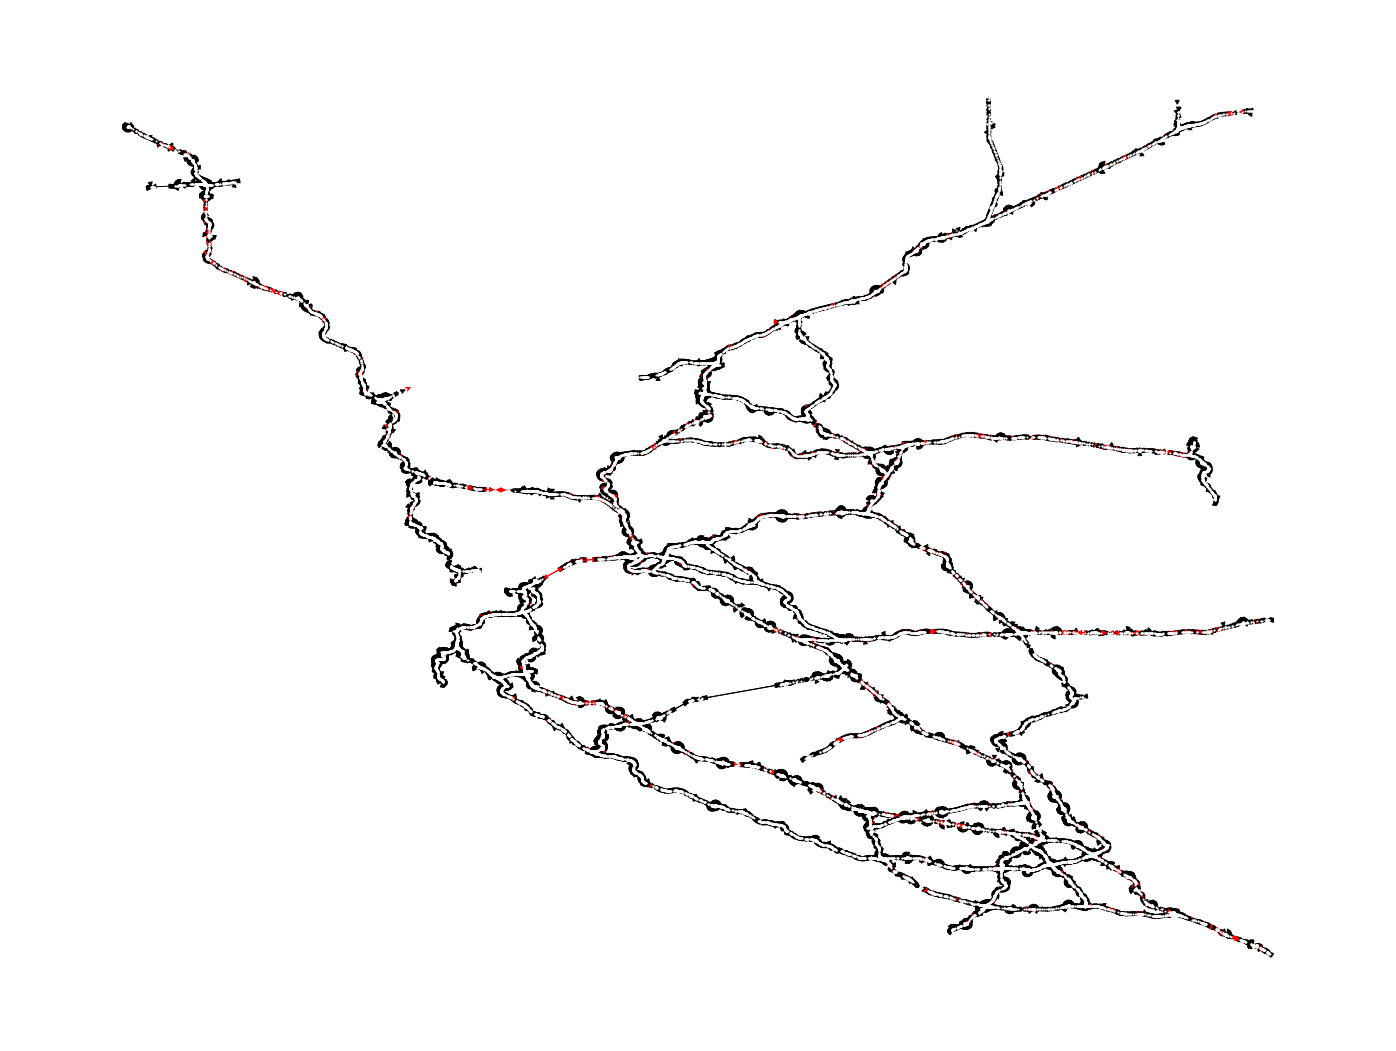

In [19]:
plt.figure(figsize=[3 * x for x in [6.4, 4.8]])

edge_colors = ["red" if G[u][v]["edge_id"] in high_err_detectors else "black" for u, v in G.edges()]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=edge_colors)

All detector locations:

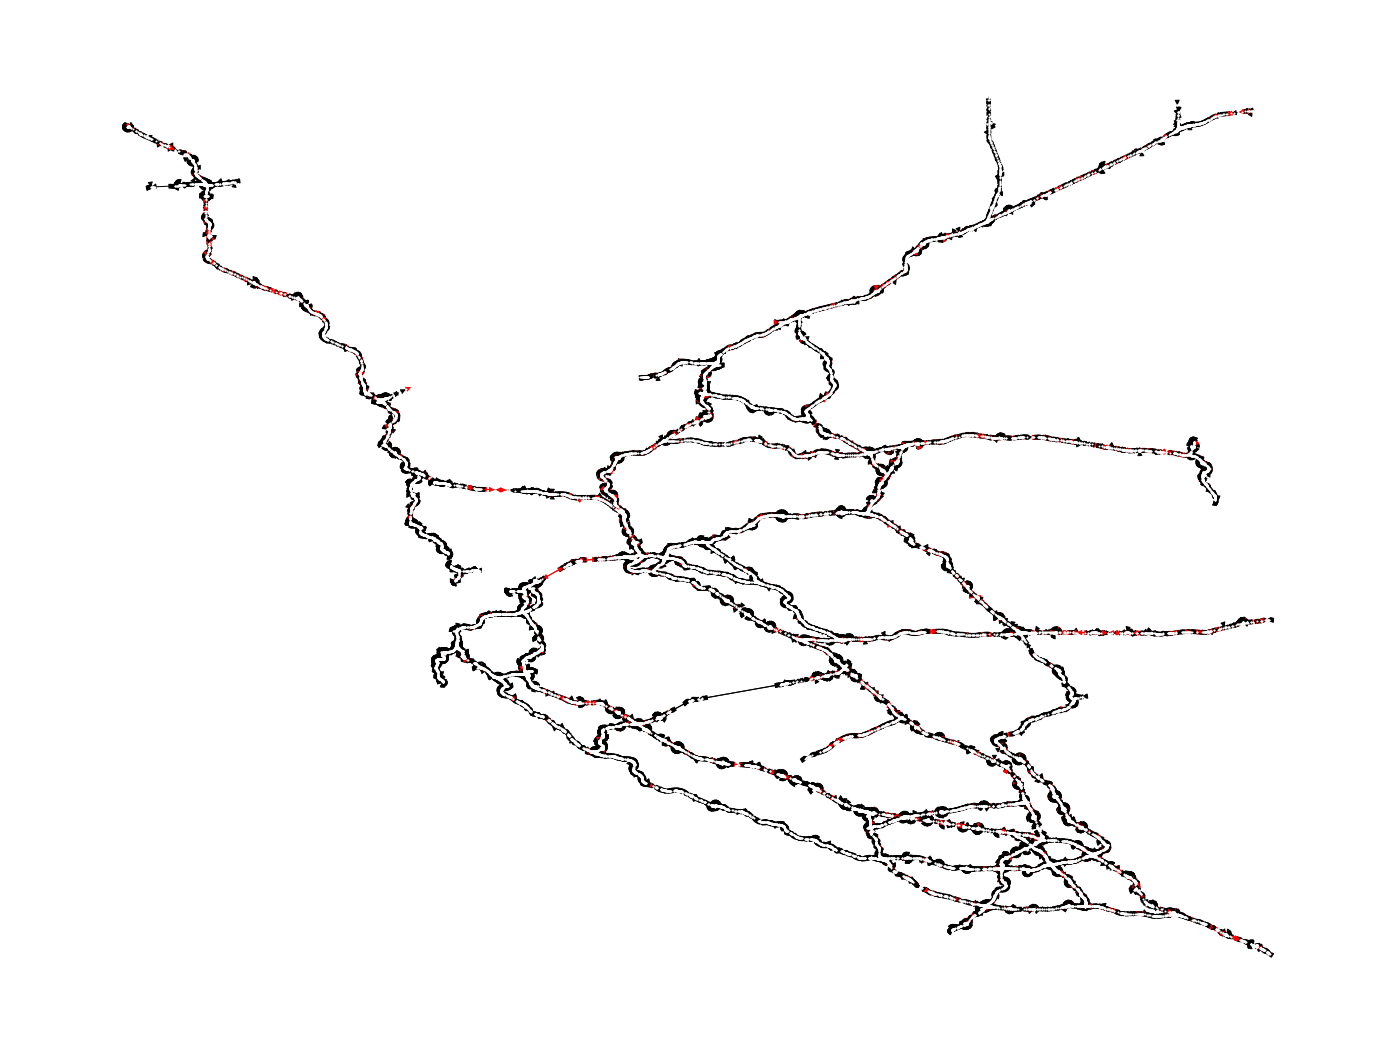

In [20]:
plt.figure(figsize=[3 * x for x in [6.4, 4.8]])

edge_colors = ["red" if G[u][v]["edge_id"] in detectors else "black" for u, v in G.edges()]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=edge_colors)

(array([14457.,  5054.,  4288.,  3827.,  5403.,  3581.,  2346.,   986.,
          384.,    53.]),
 array([   0. ,  587.2, 1174.4, 1761.6, 2348.8, 2936. , 3523.2, 4110.4,
        4697.6, 5284.8, 5872. ]),
 <BarContainer object of 10 artists>)

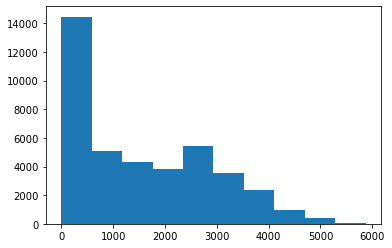

In [21]:
plt.hist([G[u][v]["flow"] for u,v in G.edges])

(array([2.441e+03, 5.900e+02, 5.300e+01, 6.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([4.25000000e+00, 3.50217124e+03, 7.00009248e+03, 1.04980137e+04,
        1.39959350e+04, 1.74938562e+04, 2.09917774e+04, 2.44896987e+04,
        2.79876199e+04, 3.14855411e+04, 3.49834624e+04]),
 <BarContainer object of 10 artists>)

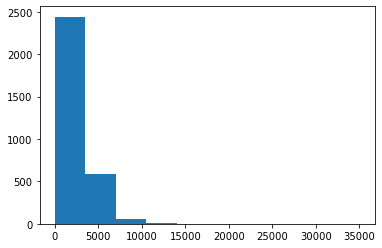

In [22]:
plt.hist(flows.values())

(array([ 1050.,   292.,   141.,   103.,   183.,   528.,  2075., 11535.,
        19113.,  5359.]),
 array([ 0.   ,  3.149,  6.298,  9.447, 12.596, 15.745, 18.894, 22.043,
        25.192, 28.341, 31.49 ]),
 <BarContainer object of 10 artists>)

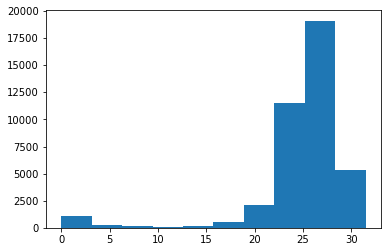

In [23]:
plt.hist(data["vehicle_speed"])

(array([  4.,  10.,  23.,  53., 179., 408., 615., 563., 163.,  15.]),
 array([21.46145692, 22.51562613, 23.56979535, 24.62396456, 25.67813378,
        26.73230299, 27.7864722 , 28.84064142, 29.89481063, 30.94897985,
        32.00314906]),
 <BarContainer object of 10 artists>)

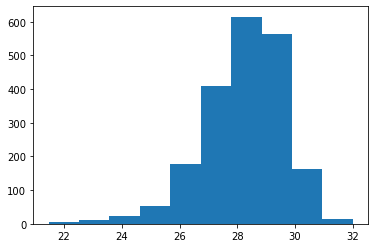

In [24]:
plt.hist([v * 0.44704 for v in speeds.values()])

## Smoothness and Estimation

In [16]:
G_undirected = nx.from_pandas_edgelist(edgelist, source="edge_from", target="edge_to", edge_attr=["edge_id", "edge_numLanes", "edge_speed",
                                                                                      "flow", "vehicle_speed"])
H = nx.line_graph(G_undirected)
H.add_nodes_from((node, G_undirected.edges[node]) for node in H)

def smoothness(H, attr):
    L = nx.laplacian_matrix(H)
    x = np.array([attrs[attr] for _, attrs in H.nodes(data=True)])
    return x.transpose() @ L @ x

smoothness(H, "vehicle_speed") / H.number_of_nodes()

7.644817377716042

In [17]:
smoothness(H, "flow") / H.number_of_nodes()

389170.25560571486

In [18]:
def fix_sensors(H, x_hat, sensors, attr):
    for i, (v, attrs) in enumerate(H.nodes(data=True)):
        if v in sensors:
            x_hat[i] = attrs[attr]

def predict(H, P, max_iter, sensors, attr):    
    x_hat = np.zeros(H.number_of_nodes())
    fix_sensors(H, x_hat, sensors, attr)        
    
    for t in range(max_iter):
        x_hat = P @ x_hat
        fix_sensors(H, x_hat, sensors, attr)
    
    return x_hat

In [ ]:
from tqdm.notebook import tqdm

def choose_sensors(H, attr, k=None):
    if k == None:
        k = int(H.number_of_nodes() / 50)
    
    # Convert node labels to 1,...,n
    node2idx = dict(zip(list(H.nodes()), range(H.number_of_nodes())))
    H = nx.relabel_nodes(H, node2idx)

    D = np.zeros((H.number_of_nodes(), H.number_of_nodes()))
    for i, v in enumerate(H.nodes()):
        D[i][i] = H.degree[v]
        
    P = np.linalg.pinv(D) @ nx.adjacency_matrix(H)
    L = nx.laplacian_matrix(H)
            
#     sensors = set()
#     for i in tqdm(range(k)):
#         candidate, best = None, float("inf")
#         for v in H.nodes():
#             pred = predict(H, P, 1000, sensors.union([v]), attr)
#             err = pred.transpose() @ L  @ pred
#             if best > err:
#                 candidate = v
#                 best = err
                
#         sensors.add(candidate)
        
#     return k

choose_sensors(H, "vehicle_speed")

init_dgesdd failed init


In [19]:
list(H.nodes())[:5]

[(120816570, 3971849316),
 (62292066, 62292068),
 (249050672, 249050676),
 (257881189, 2749875298),
 (1316890814, 1316890842)]

In [ ]:
# check new benefit for best not-picked sensor
# compare to old benefit for all others
# if benefits cna only decrease then choose the first

# also try selection by:
# maximum flow edge
# largest degree edge

In [29]:
G.number_of_nodes()

40281